Basic SVM

In [11]:
import zipfile
import pandas as pd
import os

# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score


In [6]:
# Load data
with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

# Divide data into test and train
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)


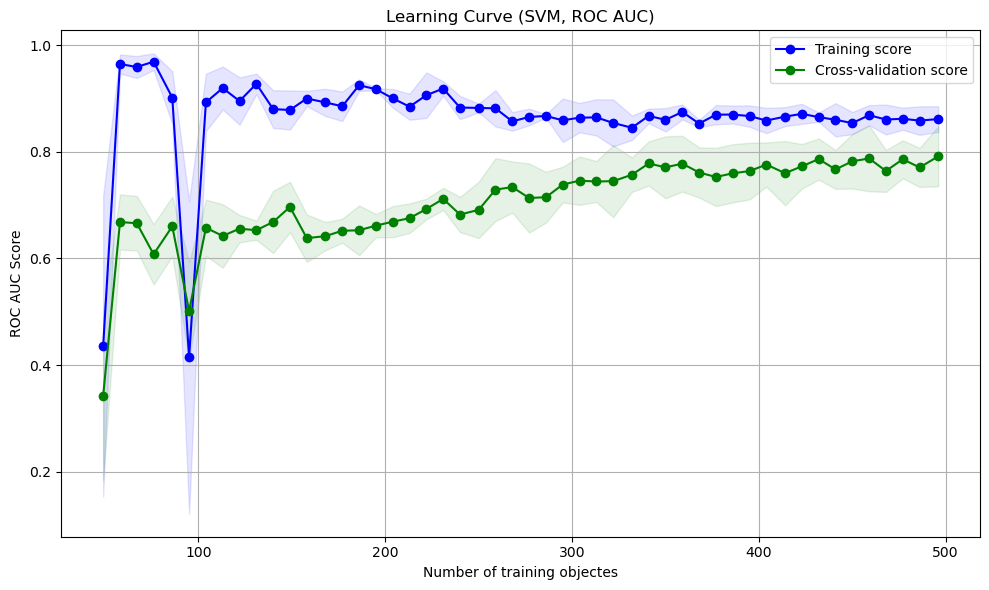

Number of Features Selected after RFECV: 20


In [18]:
# ====== PRE-FEATURE SELECTION (Before Pipeline) ======
# Optionally apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=50)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)
cv = StratifiedKFold(n_splits=5)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')

# Create a pipeline with feature selection, scaling, and SVM classification
pipeline = Pipeline([
    ('feature_selection', rfecv),  # RFECV for feature selection
    ('svm', svm)
])

pipeline.fit(X_train_reduced, y_train)

#Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    pipeline,
    X_train_reduced,
    y_train,
    cv=5,
    scoring= 'roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 50),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (SVM, ROC AUC)")
plt.xlabel("Number of training objectes")
plt.ylabel("ROC AUC Score")

plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1, color="blue")

plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.tight_layout()
plt.show()

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")

In [ ]:
#Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 20),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (SVM, ROC AUC)")
plt.xlabel("Number of training objectes")
plt.ylabel("ROC AUC Score")

plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")

plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.tight_layout()
plt.show()